In [2]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
import random

In [3]:
class AgentState(TypedDict):
    player_name:str
    guesses:list[int]
    attempts:int
    lower_bound:int
    upper_bound:int

In [4]:
# Set the target number (this would normally be hidden from the player)
TARGET_NUMBER = random.randint(1, 20)

def guessing_node(state: AgentState) -> AgentState:
    """Generate a guess within the current bounds"""
    # Generate a random guess within the current bounds
    guess = random.randint(state['lower_bound'], state['upper_bound'])
    
    # Add the guess to the list
    state['guesses'].append(guess)
    state['attempts'] += 1
    
    print(f"Attempt {state['attempts']}: Guessing {guess}")
    
    return state

def hint_node(state: AgentState) -> AgentState:
    """Provide hint about whether the guess is higher or lower"""
    if not state['guesses']:
        return state
    
    last_guess = state['guesses'][-1]
    
    if last_guess == TARGET_NUMBER:
        print(f"🎉 Correct! The number was {TARGET_NUMBER}")
        print(f"Game won in {state['attempts']} attempts!")
    elif last_guess < TARGET_NUMBER:
        print(f"Hint: The number is HIGHER than {last_guess}")
        # Update lower bound
        state['lower_bound'] = last_guess + 1
    else:
        print(f"Hint: The number is LOWER than {last_guess}")
        # Update upper bound
        state['upper_bound'] = last_guess - 1
    
    return state

def should_continue(state: AgentState) -> str:
    """Decide whether to continue guessing or end the game"""
    if not state['guesses']:
        return 'guess'
    
    last_guess = state['guesses'][-1]
    
    # Check if we guessed correctly
    if last_guess == TARGET_NUMBER:
        print("🎉 Game won!")
        return 'end'
    
    # Check if we've reached maximum attempts
    if state['attempts'] >= 7:
        print(f"❌ Game over! Maximum attempts reached. The number was {TARGET_NUMBER}")
        return 'end'
    
    # Check if bounds are invalid (no more possible numbers)
    if state['lower_bound'] > state['upper_bound']:
        print("❌ Game over! No more valid numbers to guess.")
        return 'end'
    
    print(f"Continuing... Bounds: {state['lower_bound']} to {state['upper_bound']}")
    return 'guess'
    

In [5]:
# Build the StateGraph
graph = StateGraph(AgentState)

# Add nodes
graph.add_node("guessing", guessing_node)
graph.add_node("hint", hint_node)

# Add edges
graph.add_edge(START, "guessing")

# Add conditional edges
graph.add_conditional_edges(
    "guessing",
    should_continue,
    {
        "guess": "hint",
        "end": END
    }
)

graph.add_conditional_edges(
    "hint",
    should_continue,
    {
        "guess": "guessing",
        "end": END
    }
)

# Compile the graph
app = graph.compile()


In [6]:
# Test the game with the provided input state
print(f"🎯 Target number: {TARGET_NUMBER} (hidden from player)")
print("=" * 50)

initial_state = {
    "player_name": "Student",
    "guesses": [],
    "attempts": 0,
    "lower_bound": 1,
    "upper_bound": 20
}

# Run the game
result = app.invoke(initial_state)

print("=" * 50)
print("🎮 Game Summary:")
print(f"Player: {result['player_name']}")
print(f"Total attempts: {result['attempts']}")
print(f"Guesses made: {result['guesses']}")
print(f"Final bounds: {result['lower_bound']} to {result['upper_bound']}")


🎯 Target number: 19 (hidden from player)
Attempt 1: Guessing 17
Continuing... Bounds: 1 to 20
Hint: The number is HIGHER than 17
Continuing... Bounds: 18 to 20
Attempt 2: Guessing 18
Continuing... Bounds: 18 to 20
Hint: The number is HIGHER than 18
Continuing... Bounds: 19 to 20
Attempt 3: Guessing 20
Continuing... Bounds: 19 to 20
Hint: The number is LOWER than 20
Continuing... Bounds: 19 to 19
Attempt 4: Guessing 19
🎉 Game won!
🎮 Game Summary:
Player: Student
Total attempts: 4
Guesses made: [17, 18, 20, 19]
Final bounds: 19 to 19


In [7]:
# Display the graph structure
print("🔄 Higher or Lower Game Flowchart")
print("=" * 50)
print()
print("    ┌─────────┐")
print("    │  START  │")
print("    └────┬────┘")
print("         │")
print("         ▼")
print("    ┌─────────┐")
print("    │guessing │")
print("    └────┬────┘")
print("         │")
print("         ▼")
print("┌─────────────────┐")
print("│ should_continue │")
print("└─────┬───────┬───┘")
print("      │       │")
print("      │       │ correct/max attempts")
print("      │       │ (end)")
print("      │       ▼")
print("      │   ┌───────┐")
print("      │   │  END  │")
print("      │   └───────┘")
print("      │")
print("      │ continue")
print("      │ (guess)")
print("      │")
print("      ▼")
print("    ┌─────────┐")
print("    │  hint   │")
print("    └────┬────┘")
print("         │")
print("         ▼")
print("┌─────────────────┐")
print("│ should_continue │")
print("└─────┬───────┬───┘")
print("      │       │")
print("      │       │ correct/max attempts")
print("      │       │ (end)")
print("      │       ▼")
print("      │   ┌───────┐")
print("      │   │  END  │")
print("      │   └───────┘")
print("      │")
print("      │ continue")
print("      │ (guess)")
print("      │")
print("      └─────────────┘")
print()
print("🎯 Flow: START → guessing → hint → guessing → ... → END")
print("   ↳ Loop continues until correct guess or max attempts (7)")

print("\n📊 Graph structure:")
print(app.get_graph())


🔄 Higher or Lower Game Flowchart

    ┌─────────┐
    │  START  │
    └────┬────┘
         │
         ▼
    ┌─────────┐
    │guessing │
    └────┬────┘
         │
         ▼
┌─────────────────┐
│ should_continue │
└─────┬───────┬───┘
      │       │
      │       │ correct/max attempts
      │       │ (end)
      │       ▼
      │   ┌───────┐
      │   │  END  │
      │   └───────┘
      │
      │ continue
      │ (guess)
      │
      ▼
    ┌─────────┐
    │  hint   │
    └────┬────┘
         │
         ▼
┌─────────────────┐
│ should_continue │
└─────┬───────┬───┘
      │       │
      │       │ correct/max attempts
      │       │ (end)
      │       ▼
      │   ┌───────┐
      │   │  END  │
      │   └───────┘
      │
      │ continue
      │ (guess)
      │
      └─────────────┘

🎯 Flow: START → guessing → hint → guessing → ... → END
   ↳ Loop continues until correct guess or max attempts (7)

📊 Graph structure:
Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=

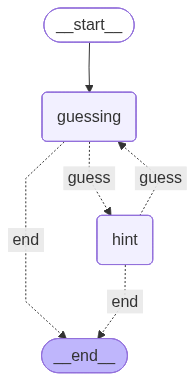

In [8]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))